## Plots figure 15

In [1]:
import simpy 
import numpy as np
from heapq import *
import pandas as pd
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
import warnings
from simulation_functions import *

In [2]:
THETA = 1000000
BETA = 5
get_delta_t = lambda u0, k0, d: (1/BETA)*np.log((u0*np.exp(d*BETA*μ(k0)) + μ(k0) - u0)/μ(k0))
distance_traveled = lambda u0, k0, delta_t: (1/μ(k0)/BETA)*np.log((μ(k0)*np.exp(delta_t*BETA) - μ(k0) + u0)/u0) 

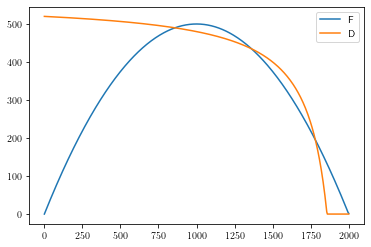

In [3]:
ks = np.linspace(0,kj,500)
plt.plot(ks,f(ks), label = 'F')
plt.plot(ks,D(μ(ks)), label = 'D')
plt.legend()

In [4]:
def get_u(u0, k0, delta_t):
    u = μ(k0) - (μ(k0) - u0)*np.exp(-BETA*delta_t)
    return u

def get_A(u0, k0, delta_t, A0):
    A = THETA*ω/(BETA*ω - THETA)*(μ(k0) - u0)*np.exp(-BETA*delta_t) + (α - ω*μ(k0)) + (A0 - THETA*ω/(BETA*ω - THETA)*(μ(k0) - u0) - (α - ω*μ(k0)))*np.exp(-THETA*delta_t/ω)
    if A < 0:
        A = 0
    return A

In [5]:
class Simulation(): 
    def __init__(self, start_density, start_inflow, start_u):
        self.li = [] 
        heapify(self.li)
        self.record= []
        self.cumm_curve = []
        self.travel = 0
        self.A0 = start_inflow
        self.u0 = start_u
        self.t0 = 0
        self.k0 = start_density
        self.env = simpy.Environment()
        self.env.process(self.arrivals(self.env,self.li))
        self.traffic = self.env.process(self.traffic(self.env,self.li))
        self.env.run(until=200)
    
    def get_record(self):
        df = pd.DataFrame(np.array(self.record),columns=('t','n','u','mu','k0','t0','u0','A0', 'record type'))
        return df

    def get_cumm_curve(self):
        df = pd.DataFrame(np.array(self.cumm_curve), columns=('t','n','u', 'type'))
        return df
        
    def arrivals(self, env,li):
        #initialize
        for i in range(self.k0):
            heappush(li,rnd_dev())
            self.k0 = len(li)
            
        while True:
            d = D(μ(len(li)))#the demand rate
            n = len(li)
            A = get_A(self.u0, self.k0, env.now - self.t0, self.A0)
            if A==0:
                yield env.timeout(0.05)
            else:
                yield env.timeout(rng.exponential(1/A))
                self.record.append([env.now,n,get_u(self.u0, self.k0, env.now - self.t0),μ(n),self.k0,self.t0,self.u0,self.A0,1])
                self.cumm_curve.append([env.now, n, μ(n),1])
                heappush(li,self.travel+rnd_dev())
                self.A0 = get_A(self.u0, self.k0, env.now - self.t0, self.A0)
                self.u0 = get_u(self.u0, self.k0, env.now - self.t0)
                self.t0 = self.env.now
                self.k0 = len(li)
                self.traffic.interrupt()

    def traffic(self,env,li):   
        while True:
            if li:
                tr = nsmallest(1,li)[0]
                n = len(li)
                u = get_u(self.u0, self.k0, env.now - self.t0)
                δ = round(get_delta_t(self.u0, self.k0, tr - self.travel), 4)
                if δ < 0:
                    print("Negative delta", env.now, self.t0, self.u0, self.k0, tr-self.travel, self.last)
                now = env.now
                try:    
                    yield env.timeout(δ)
                    self.record.append([env.now,n,get_u(self.u0, self.k0, env.now - self.t0),μ(n),self.k0,self.t0,self.u0,self.A0,0])
                    self.travel = heappop(li)
                    self.cumm_curve.append([env.now, n, μ(n),0])
                    self.A0 = get_A(self.u0, self.k0, env.now - self.t0, self.A0)
                    self.u0 = get_u(self.u0, self.k0, env.now - self.t0)
                    self.t0 = self.env.now
                    self.k0 = len(li)
                except simpy.Interrupt:
                    self.travel = self.travel + distance_traveled(self.u0, self.k0, env.now - now)
                    self.A0 = get_A(self.u0, self.k0, env.now - self.t0, self.A0)
                    self.u0 = get_u(self.u0, self.k0, env.now - self.t0)
                    self.t0 = self.env.now
                    self.k0 = len(li)
                    self.last = "exception"
                

In [6]:
sim1 = Simulation(1600, 700, 2)
sim2 = Simulation(1100, 300, 2)
sim3 = Simulation(2000,500,1)
sim4 = Simulation(1,200,1)

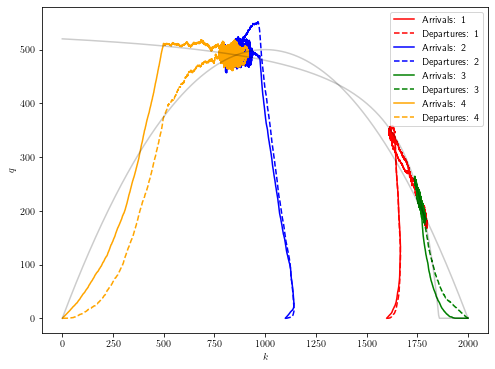

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_cumm_curve([sim1, sim2, sim3, sim4], save = "../../fig/kAu_model/sim/logn_traj.pdf")

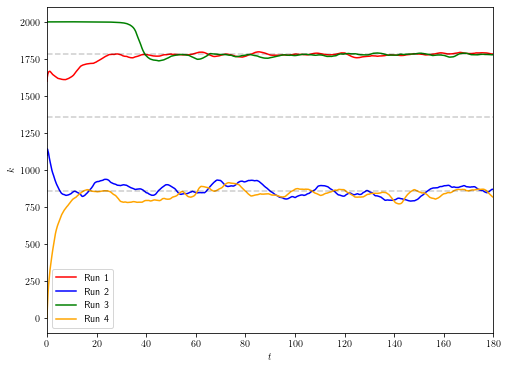

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_Tn_curve([sim1, sim2, sim3, sim4], save = "../../fig/kAu_model/sim/logn_Tn.pdf")